In [3]:
#!/usr/bin/env python
from uproot_methods import TVector2Array, TLorentzVectorArray
from optparse import OptionParser
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from coffea.util import load, save
from coffea import hist, processor
from coffea.arrays import Initialize
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import math
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [14]:
class AnalysisProcessor(processor.ProcessorABC):

    lumis = {  # Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
        '2016': 35.92,
        '2017': 40.66,
        '2018': 59.74
    }

    met_filter_flags = {

        '2016': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter'
                 ],

        '2017': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter',
                 'ecalBadCalibFilterV2'
                 ],

        '2018': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter',
                 'ecalBadCalibFilterV2'
                 ]
    }

    def __init__(self, year, xsec, corrections, ids, common):

        self._columns = """
        CaloMET_pt
        CaloMET_phi
        Electron_charge
        Electron_cutBased
        Electron_dxy
        Electron_dz
        Electron_eta
        Electron_mass
        Electron_phi
        Electron_pt
        Flag_BadPFMuonFilter
        Flag_EcalDeadCellTriggerPrimitiveFilter
        Flag_HBHENoiseFilter
        Flag_HBHENoiseIsoFilter
        Flag_globalSuperTightHalo2016Filter
        Flag_goodVertices
        GenPart_eta
        GenPart_genPartIdxMother
        GenPart_pdgIdGenPart_phi
        GenPart_pt
        GenPart_statusFlags
        HLT_Ele115_CaloIdVT_GsfTrkIdT
        HLT_Ele32_WPTight_Gsf
        HLT_PFMETNoMu120_PFMHTNoMu120_IDTight
        HLT_PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60
        HLT_Photon200
        Jet_btagDeepB
        Jet_btagDeepFlavB
        Jet_chEmEF
        Jet_chHEF
        Jet_eta
        Jet_hadronFlavour
        Jet_jetId
        Jet_mass
        Jet_neEmEF
        Jet_neHEF
        Jet_phi
        Jet_pt
        Jet_rawFactor
        MET_phi
        MET_pt
        Muon_charge
        Muon_eta
        Muon_looseId
        Muon_mass
        Muon_pfRelIso04_all
        Muon_phi
        Muon_pt
        Muon_tightId
        PV_npvs
        Photon_eta
        Photon_phi
        Photon_pt
        Tau_eta
        Tau_idDecayMode
        Tau_idMVAoldDM2017v2
        Tau_phi
        Tau_pt
        fixedGridRhoFastjetAll
        genWeight
        nElectron
        nGenPart
        nJet
        nMuon
        nPhoton
        nTau
        """.split()

        self._year = year

        self._lumi = 1000.*float(AnalysisProcessor.lumis[year])

        self._xsec = xsec
        if self._year == '2016':
            data_electron = 'SingleElectron'
            data_muon = 'SingleMuon'
        elif self._year == '2017':
            data_electron = 'SingleElectron'
            data_muon = 'SingleMuon'
        elif self._year == '2018':
            data_electron = 'EGamma'
            data_muon = 'MET'
        self._samples = {
            'sre': ('WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', data_electron),
            'srm': ('WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', data_muon),
            'ttbare': ('WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', data_electron),
            'ttbarm': ('WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', data_muon),
            'wjete': ('WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', data_electron),
            'wjetm': ('WJets', 'DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', 'QCD', data_muon),
            #             'dilepe': ('DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', data_electron),
            #             'dilepm': ('DY', 'TT', 'ST', 'WW', 'WZ', 'ZZ', data_muon)

        }

        self._gentype_map = {
            'xbb':      1,
            'tbcq':     2,
            'tbqq':     3,
            'zcc':      4,
            'wcq':      5,
            'vqq':      6,
            'bb':       7,
            'bc':       8,
            'b':        9,
            'cc':     10,
            'c':       11,
            'other':   12
            # 'garbage': 13
        }

        self._ZHbbvsQCDwp = {
            '2016': 0.53,
            '2017': 0.61,
            '2018': 0.65
        }

        self._met_triggers = {
            '2016': [
                'PFMETNoMu90_PFMHTNoMu90_IDTight',
                'PFMETNoMu100_PFMHTNoMu100_IDTight',
                'PFMETNoMu110_PFMHTNoMu110_IDTight',
                'PFMETNoMu120_PFMHTNoMu120_IDTight'
            ],
            '2017': [
                'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                'PFMETNoMu120_PFMHTNoMu120_IDTight'
            ],
            '2018': [
                'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                'PFMETNoMu120_PFMHTNoMu120_IDTight'
            ]
        }

        self._singlephoton_triggers = {
            '2016': [
                'Photon175',
                'Photon165_HE10'
            ],
            '2017': [
                'Photon200'
            ],
            '2018': [
                'Photon200'
            ]
        }

        self._singleelectron_triggers = {  # 2017 and 2018 from monojet, applying dedicated trigger weights
            '2016': [
                'Ele27_WPTight_Gsf',
                'Ele105_CaloIdVT_GsfTrkIdT'
            ],
            '2017': [
                'Ele35_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200'
            ],
            '2018': [
                'Ele32_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200'
            ]
        }
        self._singlemuon_triggers = {
            '2016': [
                'IsoMu24',
                'IsoTkMu24',
                'Mu50',
                'TkMu50'

            ],
            '2017':
                [
                'IsoMu27',
                'Mu50',
                'OldMu100',
                'TkMu100'
            ],
            '2018':
                [
                'IsoMu24',
                'Mu50',
                'OldMu100',
                'TkMu100'
            ]
        }

        self._jec = {

            '2016': [
                'Summer16_07Aug2017_V11_MC_L1FastJet_AK4PFPuppi',
                'Summer16_07Aug2017_V11_MC_L2L3Residual_AK4PFPuppi',
                'Summer16_07Aug2017_V11_MC_L2Relative_AK4PFPuppi',
                'Summer16_07Aug2017_V11_MC_L2Residual_AK4PFPuppi',
                'Summer16_07Aug2017_V11_MC_L3Absolute_AK4PFPuppi'
            ],

            '2017': [
                'Fall17_17Nov2017_V32_MC_L1FastJet_AK4PFPuppi',
                'Fall17_17Nov2017_V32_MC_L2L3Residual_AK4PFPuppi',
                'Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi',
                'Fall17_17Nov2017_V32_MC_L2Residual_AK4PFPuppi',
                'Fall17_17Nov2017_V32_MC_L3Absolute_AK4PFPuppi'
            ],

            '2018': [
                'Autumn18_V19_MC_L1FastJet_AK4PFPuppi',
                'Autumn18_V19_MC_L2L3Residual_AK4PFPuppi',
                'Autumn18_V19_MC_L2Relative_AK4PFPuppi',  # currently broken
                'Autumn18_V19_MC_L2Residual_AK4PFPuppi',
                'Autumn18_V19_MC_L3Absolute_AK4PFPuppi'
            ]
        }

        self._junc = {

            '2016': [
                'Summer16_07Aug2017_V11_MC_Uncertainty_AK4PFPuppi'
            ],

            '2017': [
                'Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi'
            ],

            '2018': [
                'Autumn18_V19_MC_Uncertainty_AK4PFPuppi'
            ]
        }

        self._jr = {

            '2016': [
                'Summer16_25nsV1b_MC_PtResolution_AK4PFPuppi'
            ],

            '2017': [
                'Fall17_V3b_MC_PtResolution_AK4PFPuppi'
            ],

            '2018': [
                'Autumn18_V7b_MC_PtResolution_AK4PFPuppi'
            ]
        }

        self._jersf = {

            '2016': [
                'Summer16_25nsV1b_MC_SF_AK4PFPuppi'
            ],

            '2017': [
                'Fall17_V3b_MC_SF_AK4PFPuppi'
            ],

            '2018': [
                'Autumn18_V7b_MC_SF_AK4PFPuppi'
            ]
        }

        self._corrections = corrections
        self._ids = ids
        self._common = common

        self._accumulator = processor.dict_accumulator({
            'sumw': hist.Hist(
                'sumw',
                hist.Cat('dataset', 'Dataset'),
                hist.Bin('sumw', 'Weight value', [0.])
            ),
            'template': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Cat('systematic', 'Systematic'),
            ),
            'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT', '$m_{T}$ [GeV]', 20, 0, 600)),
            'eT_miss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('eT_miss', '$E^T_{miss}$[GeV]', 20, 0, 600)),

            'ele_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('ele_pT', 'Tight electron $p_{T}$ [GeV]', 10, 0, 200)),

            'mu_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mu_pT', 'Tight Muon $p_{T}$ [GeV]', 10, 0, 200)),

            'jet_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('jet_pT', 'Leading $AK4 Jet p_{T}$ [GeV]',
                         [30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 250.0, 280.0, 310.0, 340.0, 370.0, 400.0, 430.0, 470.0, 510.0, 550.0, 590.0, 640.0, 690.0, 740.0, 790.0, 840.0, 900.0, 960.0, 1020.0, 1090.0, 1160.0, 1250.0])),
            'dphi_e_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi_e_etmiss', '$\Delta\phi (e, E^T_{miss} )$', 30, 0, 3.5)),
            'dphi_mu_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi_mu_etmiss',
                         '$\Delta\phi (\mu, E^T_{miss} )$', 30, 0, 3.5)),
            'ndflvL': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('ndflvL', 'AK4 Number of deepFlavor Loose Jets', 6, -0.5, 5.5)),
            'njets': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('njets', 'AK4 Number of Jets', 6, -0.5, 5.5)),

            'ndcsvM': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('ndcsvM', 'AK4 Number of deepCSV Medium Jets', 6, -0.5, 5.5)),
            'dphi_Met_LJ': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi_Met_LJ', '$\Delta \Phi (E^T_{miss}, leading_jet)$', 30, 0, 3.5)),
            'dr_e_lj': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dr_e_lj', '$\Delta r (e, leading_jet)$', 30, 0, 5.0)),
            'dr_mu_lj': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dr_mu_lj', '$\Delta r (\mu, leading_jet)$', 30, 0, 5.0)),
        })

    @property
    def accumulator(self):
        return self._accumulator

    @property
    def columns(self):
        return self._columns

    def process(self, events):

        dataset = events.metadata['dataset']

        selected_regions = []
        for region, samples in self._samples.items():
            for sample in samples:
                if sample not in dataset:
                    continue
                selected_regions.append(region)

        isData = 'genWeight' not in events.columns
        selection = processor.PackedSelection()
        hout = self.accumulator.identity()

        ###
        # Getting corrections, ids from .coffea files
        ###

        get_msd_weight = self._corrections['get_msd_weight']
        get_ttbar_weight = self._corrections['get_ttbar_weight']
        get_nnlo_nlo_weight = self._corrections['get_nnlo_nlo_weight'][self._year]
        get_nlo_qcd_weight = self._corrections['get_nlo_qcd_weight'][self._year]
        get_nlo_ewk_weight = self._corrections['get_nlo_ewk_weight'][self._year]
        get_pu_weight = self._corrections['get_pu_weight'][self._year]
        get_met_trig_weight = self._corrections['get_met_trig_weight'][self._year]
        get_met_zmm_trig_weight = self._corrections['get_met_zmm_trig_weight'][self._year]
        get_ele_trig_weight = self._corrections['get_ele_trig_weight'][self._year]
        get_pho_trig_weight = self._corrections['get_pho_trig_weight'][self._year]
        get_ele_loose_id_sf = self._corrections['get_ele_loose_id_sf'][self._year]
        get_ele_tight_id_sf = self._corrections['get_ele_tight_id_sf'][self._year]
        get_pho_tight_id_sf = self._corrections['get_pho_tight_id_sf'][self._year]
        get_pho_csev_sf = self._corrections['get_pho_csev_sf'][self._year]
        get_mu_tight_id_sf = self._corrections['get_mu_tight_id_sf'][self._year]
        get_mu_loose_id_sf = self._corrections['get_mu_loose_id_sf'][self._year]
        get_ele_reco_sf = self._corrections['get_ele_reco_sf'][self._year]
        get_ele_reco_lowet_sf = self._corrections['get_ele_reco_lowet_sf']
        get_mu_tight_iso_sf = self._corrections['get_mu_tight_iso_sf'][self._year]
        get_mu_loose_iso_sf = self._corrections['get_mu_loose_iso_sf'][self._year]
        get_ecal_bad_calib = self._corrections['get_ecal_bad_calib']
        get_deepflav_weight = self._corrections['get_btag_weight']['deepflav'][self._year]
        get_deepcsv_weight = self._corrections['get_btag_weight']['deepcsv'][self._year]
        Jetevaluator = self._corrections['Jetevaluator']

        isLooseElectron = self._ids['isLooseElectron']
        isTightElectron = self._ids['isTightElectron']
        isLooseMuon = self._ids['isLooseMuon']
        isTightMuon = self._ids['isTightMuon']
        isLooseTau = self._ids['isLooseTau']
        isLoosePhoton = self._ids['isLoosePhoton']
        isTightPhoton = self._ids['isTightPhoton']
        isGoodJet = self._ids['isGoodJet']
        isHEMJet = self._ids['isHEMJet']

        match = self._common['match']
        # to calculate photon trigger efficiency
        sigmoid = self._common['sigmoid']
        deepflavWPs = self._common['btagWPs']['deepflav'][self._year]
        deepcsvWPs = self._common['btagWPs']['deepcsv'][self._year]

        ###
        # Derive jet corrector for JEC/JER
        ###

        JECcorrector = FactorizedJetCorrector(
            **{name: Jetevaluator[name] for name in self._jec[self._year]})
        JECuncertainties = JetCorrectionUncertainty(
            **{name: Jetevaluator[name] for name in self._junc[self._year]})
        JER = JetResolution(
            **{name: Jetevaluator[name] for name in self._jr[self._year]})
        JERsf = JetResolutionScaleFactor(
            **{name: Jetevaluator[name] for name in self._jersf[self._year]})
        Jet_transformer = JetTransformer(
            jec=JECcorrector, junc=JECuncertainties, jer=JER, jersf=JERsf)

        ###
        # Initialize global quantities (MET ecc.)
        ###

        met = events.MET
        if self._year == '2017':
            events.METFixEE2017  # Recommended for 2017
        met['T'] = TVector2Array.from_polar(met.pt, met.phi)
        calomet = events.CaloMET
        puppimet = events.PuppiMET

        ###
        # Initialize physics objects
        ###

        mu = events.Muon
        mu['isloose'] = isLooseMuon(
            mu.pt, mu.eta, mu.pfRelIso04_all, mu.looseId, self._year)
        mu['istight'] = isTightMuon(
            mu.pt, mu.eta, mu.pfRelIso04_all, mu.tightId, self._year)
        mu['T'] = TVector2Array.from_polar(mu.pt, mu.phi)
        mu['p4'] = TLorentzVectorArray.from_ptetaphim(
            mu.pt, mu.eta, mu.phi, mu.mass)
        mu_loose = mu[mu.isloose.astype(np.bool)]
        mu_tight = mu[mu.istight.astype(np.bool)]
        mu_ntot = mu.counts
        mu_nloose = mu_loose.counts
        mu_ntight = mu_tight.counts
        leading_mu = mu[mu.pt.argmax()]
        leading_mu = leading_mu[leading_mu.istight.astype(np.bool)]

        e = events.Electron
        e['isclean'] = ~match(e, mu_loose, 0.3)
        e['isloose'] = isLooseElectron(
            e.pt, e.eta+e.deltaEtaSC, e.dxy, e.dz, e.cutBased, self._year)
        e['istight'] = isTightElectron(
            e.pt, e.eta+e.deltaEtaSC, e.dxy, e.dz, e.cutBased, self._year)
        e['T'] = TVector2Array.from_polar(e.pt, e.phi)
        e['p4'] = TLorentzVectorArray.from_ptetaphim(
            e.pt, e.eta, e.phi, e.mass)
        e_clean = e[e.isclean.astype(np.bool)]
        e_loose = e_clean[e_clean.isloose.astype(np.bool)]
        e_tight = e_clean[e_clean.istight.astype(np.bool)]
        e_ntot = e.counts
        e_nloose = e_loose.counts
        e_ntight = e_tight.counts
        leading_e = e[e.pt.argmax()]
        leading_e = leading_e[leading_e.isclean.astype(np.bool)]
        leading_e = leading_e[leading_e.istight.astype(np.bool)]

        tau = events.Tau
        tau['isclean'] = ~match(tau, mu_loose, 0.4) & ~match(tau, e_loose, 0.4)
        tau['isloose'] = isLooseTau(
            tau.pt, tau.eta, tau.idDecayMode, tau.idMVAoldDM2017v2, self._year)
        tau_clean = tau[tau.isclean.astype(np.bool)]
        tau_loose = tau_clean[tau_clean.isloose.astype(np.bool)]
        tau_ntot = tau.counts
        tau_nloose = tau_loose.counts

        pho = events.Photon
        pho['isclean'] = ~match(pho, mu_loose, 0.5) & ~match(pho, e_loose, 0.5)
        _id = 'cutBasedBitmap'
        if self._year == '2016':
            _id = 'cutBased'
        pho['isloose'] = isLoosePhoton(pho.pt, pho.eta, pho[_id], self._year) & (
            pho.electronVeto)  # added electron veto flag
        pho['istight'] = isTightPhoton(pho.pt, pho[_id], self._year) & (
            pho.isScEtaEB) & (pho.electronVeto)  # tight photons are barrel only
        pho['T'] = TVector2Array.from_polar(pho.pt, pho.phi)
        pho_clean = pho[pho.isclean.astype(np.bool)]
        pho_loose = pho_clean[pho_clean.isloose.astype(np.bool)]
        pho_tight = pho_clean[pho_clean.istight.astype(np.bool)]
        pho_ntot = pho.counts
        pho_nloose = pho_loose.counts
        pho_ntight = pho_tight.counts
        leading_pho = pho[pho.pt.argmax()]
        leading_pho = leading_pho[leading_pho.isclean.astype(np.bool)]
        leading_pho = leading_pho[leading_pho.istight.astype(np.bool)]

        j = events.Jet
        j['isgood'] = isGoodJet(j.pt, j.eta, j.jetId, j.puId, j.neHEF, j.chHEF)
        j['isHEM'] = isHEMJet(j.pt, j.eta, j.phi)
        j['isclean'] = ~match(j, e_loose, 0.4) & ~match(
            j, mu_loose, 0.4) & ~match(j, pho_loose, 0.4)
#         print(j.isclean)

#         j['isiso'] = ~match(j,j[j.pt.argmax()],0.4)
        j['isdcsvL'] = (j.btagDeepB > deepcsvWPs['loose'])
        j['isdflvL'] = (j.btagDeepFlavB > deepflavWPs['loose'])
        j['isdcsvM'] = (j.btagDeepB > deepcsvWPs['medium'])
        j['T'] = TVector2Array.from_polar(j.pt, j.phi)
        j['p4'] = TLorentzVectorArray.from_ptetaphim(
            j.pt, j.eta, j.phi, j.mass)
        j['ptRaw'] = j.pt * (1-j.rawFactor)
        j['massRaw'] = j.mass * (1-j.rawFactor)
        j['rho'] = j.pt.ones_like()*events.fixedGridRhoFastjetAll.array
        j_good = j[j.isgood.astype(np.bool)]
        j_clean = j[j.isclean.astype(np.bool)]
#         print(j_c)
#         j_iso = j_clean[j_clean.isiso.astype(np.bool)]
#         j_iso=j_clean[j_clean.astype(np.bool)]  # Sunil changed
        j_dcsvL=j_clean[j_clean.isdcsvL.astype(np.bool)]
        j_dflvL=j_clean[j_clean.isdflvL.astype(np.bool)]
        j_dcsvM=j_clean[j_clean.isdcsvM.astype(np.bool)]
        j_HEM = j[j.isHEM.astype(np.bool)]
        j_ntot = j.counts
        j_ngood = j_good.counts
        j_nclean = j_clean.counts
#         j_niso=j_iso.counts
        j_ndcsvL=j_dcsvL.counts
        j_ndflvL=j_dflvL.counts
        j_ndcsvM=j_dcsvM.counts
        j_nHEM = j_HEM.counts
        leading_j = j[j.pt.argmax()]
        leading_j = leading_j[leading_j.isgood.astype(np.bool)]
        leading_j = leading_j[leading_j.isclean.astype(np.bool)]
        # *****btag
        # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X#Supported_Algorithms_and_Operati
        # medium     0.4184
        btagWP_medium = 0.4184
        Jet_btag_medium = j_clean[j_clean['btagDeepB'] > btagWP_medium]
        ###
        # Calculating derivatives
        ###

        # ************ calculate delta phi( leading ak4jet, met) > 1.5***********

        j['T'] = TVector2Array.from_polar(j.pt, j.phi)
        j['p4'] = TLorentzVectorArray.from_ptetaphim(
            j.pt, j.eta, j.phi, j.mass)

        Delta_Phi_Met_LJ = (met['T'].delta_phi(leading_j['T'].sum()) > 1.5)

        # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
        LJ_Ele = leading_j['p4'].cross(e_tight['p4'])
        DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
        DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele < 3.4).any()

        LJ_Mu = leading_j['p4'].cross(mu_tight['p4'])
        DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
        DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu < 3.4).any()

        ele_pairs = e_loose.distincts()
        diele = ele_pairs.i0+ele_pairs.i1
        diele['T'] = TVector2Array.from_polar(diele.pt, diele.phi)
        leading_ele_pair = ele_pairs[diele.pt.argmax()]
        leading_diele = diele[diele.pt.argmax()]

        mu_pairs = mu_loose.distincts()
        dimu = mu_pairs.i0+mu_pairs.i1
        dimu['T'] = TVector2Array.from_polar(dimu.pt, dimu.phi)
        leading_mu_pair = mu_pairs[dimu.pt.argmax()]
        leading_dimu = dimu[dimu.pt.argmax()]

        ###
        # Calculate recoil and transverse mass
        ###

        u = {
            'sre': met.T+leading_e.T.sum(),
            'srm': met.T+leading_mu.T.sum(),
            'ttbare': met.T+leading_e.T.sum(),
            'ttbarm': met.T+leading_mu.T.sum(),
            'wjete': met.T+leading_e.T.sum(),
            'wjetm': met.T+leading_mu.T.sum(),
            # 'dilepe': met.T+leading_diele.T.sum(),
            # 'dilepm': met.T+leading_dimu.T.sum(),
            # 'gcr'   : met.T+leading_pho.T.sum()
        }

        mT = {
            'sre': np.sqrt(2*leading_e.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_e.T.sum())))),
            'srm': np.sqrt(2*leading_mu.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_mu.T.sum())))),
            'ttbare': np.sqrt(2*leading_e.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_e.T.sum())))),
            'ttbarm': np.sqrt(2*leading_mu.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_mu.T.sum())))),
            'wjete': np.sqrt(2*leading_e.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_e.T.sum())))),
            'wjetm': np.sqrt(2*leading_mu.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_mu.T.sum()))))
        }

        LTe = leading_e.pt.sum() + met.pt
        LTm = leading_mu.pt.sum() + met.pt
        mT_misET = {
            'sre': np.sqrt(2*leading_e.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_e.T.sum())))),
            'srm': np.sqrt(2*leading_mu.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_mu.T.sum())))),
            'ttbare': np.sqrt(2*leading_e.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_e.T.sum())))),
            'ttbarm': np.sqrt(2*leading_mu.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_mu.T.sum())))),
            'wjete': np.sqrt(2*leading_e.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_e.T.sum())))),
            'wjetm': np.sqrt(2*leading_mu.pt.sum()*met.pt*(1-np.cos(met.T.delta_phi(leading_mu.T.sum()))))
        }
#         Lpe=leading_e.pt / u.mag * \
#             cos(abs(u[region].delta_phi(leading_e.T)).min())
#         Lpm=leading_mu.pt / u.mag * \
#             cos(abs(u[region].delta_phi(leading_mu.T)).min())

#         dPhi=abs(dPhiLepW)  # nickname for absolute dPhiLepW
    # MT = sqrt(2*metp4.Pt()*tightLeps[0].pt * (1-cos(dPhiLepW)))   # mT_{W}

        ###
        # Calculating weights
        ###
        if not isData:

            ###
            # JEC/JER
            ###

            # j['ptGenJet'] = j.matched_gen.pt
            # Jet_transformer.transform(j)

            gen = events.GenPart

            gen['isb'] = (abs(gen.pdgId) == 5) & gen.hasFlags(
                ['fromHardProcess', 'isLastCopy'])

            gen['isc'] = (abs(gen.pdgId) == 4) & gen.hasFlags(
                ['fromHardProcess', 'isLastCopy'])

            gen['isTop'] = (abs(gen.pdgId) == 6) & gen.hasFlags(
                ['fromHardProcess', 'isLastCopy'])
            genTops = gen[gen.isTop]
            ttjet_weights = np.ones(events.size)
            if('TTJets' in dataset):
                ttjet_weights = np.sqrt(get_ttbar_weight(
                    genTops.pt.sum()) * get_ttbar_weight(genTops.pt.sum()))

            gen['isW'] = (abs(gen.pdgId) == 24) & gen.hasFlags(
                ['fromHardProcess', 'isLastCopy'])
            gen['isZ'] = (abs(gen.pdgId) == 23) & gen.hasFlags(
                ['fromHardProcess', 'isLastCopy'])
            gen['isA'] = (abs(gen.pdgId) == 22) & gen.hasFlags(
                ['isPrompt', 'fromHardProcess', 'isLastCopy']) & (gen.status == 1)

            ###
            # Calculating gen photon dynamic isolation as in https://arxiv.org/pdf/1705.04664.pdf
            ###

            epsilon_0_dyn = 0.1
            n_dyn = 1
            gen['R_dyn'] = (91.1876/(gen.pt * np.sqrt(epsilon_0_dyn))) * \
                (gen.isA).astype(np.int) + \
                (-999)*(~gen.isA).astype(np.int)
            gen['R_0_dyn'] = gen.R_dyn * \
                (gen.R_dyn < 1.0).astype(np.int) + \
                (gen.R_dyn >= 1.0).astype(np.int)

            def isolation(R):
                hadrons = gen[  # Stable hadrons not in NanoAOD, using quarks/glouns instead
                    ((abs(gen.pdgId) <= 5) | (abs(gen.pdgId) == 21)) &
                    gen.hasFlags(['fromHardProcess', 'isFirstCopy'])
                ]
                genhadrons = gen.cross(hadrons, nested=True)
                hadronic_et = genhadrons.i1[(
                    genhadrons.i0.delta_r(genhadrons.i1) <= R)].pt.sum()
                return (hadronic_et <= (epsilon_0_dyn * gen.pt * np.power((1 - np.cos(R)) / (1 - np.cos(gen.R_0_dyn)), n_dyn))) | (hadrons.counts == 0)

            isIsoA = gen.isA
            iterations = 5.
            for i in range(1, int(iterations) + 1):
                isIsoA = isIsoA & isolation(gen.R_0_dyn*i/iterations)
            gen['isIsoA'] = isIsoA

            genWs = gen[gen.isW & (gen.pt > 100)]
            genZs = gen[gen.isZ & (gen.pt > 100)]
            genDYs = gen[gen.isZ & (gen.mass > 30)]
            # Based on photon weight distribution
            genIsoAs = gen[gen.isIsoA & (gen.pt > 100)]

            nnlo_nlo = {}
            nlo_qcd = np.ones(events.size)
            nlo_ewk = np.ones(events.size)
            if('GJets' in dataset):
                if self._year == '2016':
                    nlo_qcd = get_nlo_qcd_weight['a'](genIsoAs.pt.max())
                    nlo_ewk = get_nlo_ewk_weight['a'](genIsoAs.pt.max())
                for systematic in get_nnlo_nlo_weight['a']:
                    nnlo_nlo[systematic] = get_nnlo_nlo_weight['a'][systematic](genIsoAs.pt.max(
                    ))*(genIsoAs.counts > 0).astype(np.int) + (~(genIsoAs.counts > 0)).astype(np.int)

            elif('WJets' in dataset):
                nlo_qcd = get_nlo_qcd_weight['w'](genWs.pt.max())
                nlo_ewk = get_nlo_ewk_weight['w'](genWs.pt.max())
                for systematic in get_nnlo_nlo_weight['w']:
                    nnlo_nlo[systematic] = get_nnlo_nlo_weight['w'][systematic](genWs.pt.max(
                    ))*(genWs.counts > 0).astype(np.int) + (~(genWs.counts > 0)).astype(np.int)

            elif('DY' in dataset):
                nlo_qcd = get_nlo_qcd_weight['dy'](genDYs.pt.max())
                nlo_ewk = get_nlo_ewk_weight['dy'](genDYs.pt.max())
                for systematic in get_nnlo_nlo_weight['dy']:
                    nnlo_nlo[systematic] = get_nnlo_nlo_weight['dy'][systematic](genZs.pt.max(
                    ))*(genZs.counts > 0).astype(np.int) + (~(genZs.counts > 0)).astype(np.int)
            elif('ZJets' in dataset):
                nlo_qcd = get_nlo_qcd_weight['z'](genZs.pt.max())
                nlo_ewk = get_nlo_ewk_weight['z'](genZs.pt.max())
                for systematic in get_nnlo_nlo_weight['z']:
                    nnlo_nlo[systematic] = get_nnlo_nlo_weight['z'][systematic](genZs.pt.max(
                    ))*(genZs.counts > 0).astype(np.int) + (~(genZs.counts > 0)).astype(np.int)

            ###
            # Calculate PU weight and systematic variations
            ###

            pu = get_pu_weight(events.Pileup.nTrueInt)

            ###
            # Trigger efficiency weight
            ###

            e1sf = get_ele_trig_weight(leading_ele_pair.i0.eta.sum()+leading_ele_pair.i0.deltaEtaSC.sum(
            ), leading_ele_pair.i0.pt.sum())*(leading_ele_pair.i0.pt.sum() > 40).astype(np.int)
            e2sf = get_ele_trig_weight(leading_ele_pair.i1.eta.sum()+leading_ele_pair.i1.deltaEtaSC.sum(
            ), leading_ele_pair.i1.pt.sum())*(leading_ele_pair.i1.pt.sum() > 40).astype(np.int)

            if self._year == '2016':
                sf = get_pho_trig_weight(leading_pho.pt.sum())
            elif self._year == '2017':  # Sigmoid used for 2017 and 2018, values from monojet
                sf = sigmoid(leading_pho.pt.sum(), 0.335, 217.91, 0.065, 0.996) / \
                    sigmoid(leading_pho.pt.sum(), 0.244, 212.34, 0.050, 1.000)
                sf[np.isnan(sf) | np.isinf(sf)] == 1
            elif self._year == '2018':
                sf = sigmoid(leading_pho.pt.sum(), 1.022, 218.39, 0.086, 0.999) / \
                    sigmoid(leading_pho.pt.sum(), 0.301, 212.83, 0.062, 1.000)
                sf[np.isnan(sf) | np.isinf(sf)] == 1

            trig = {
                'sre' : get_met_trig_weight(leading_e.eta.sum(),leading_e.pt.sum()),
                'srm' : get_met_trig_weight(leading_mu.eta.sum(),leading_mu.pt.sum()),
                'ttbare' : get_met_trig_weight(leading_e.eta.sum(),leading_e.pt.sum()),
                'ttbarm' : get_met_trig_weight(leading_mu.eta.sum(),leading_mu.pt.sum()),
                'wjete' : get_met_trig_weight(leading_e.eta.sum(),leading_e.pt.sum()),
                'wjetm' : get_met_trig_weight(leading_mu.eta.sum(),leading_mu.pt.sum()),
                'dilepe' : get_met_trig_weight(leading_e.eta.sum(),leading_e.pt.sum()),
                'dilepm' : get_met_trig_weight(leading_mu.eta.sum(),leading_mu.pt.sum()),
            }

            ###
            # Calculating electron and muon ID weights
            ###

            mueta = abs(leading_mu.eta.sum())
            mu1eta = abs(leading_mu_pair.i0.eta.sum())
            mu2eta = abs(leading_mu_pair.i1.eta.sum())
            if self._year == '2016':
                mueta = leading_mu.eta.sum()
                mu1eta = leading_mu_pair.i0.eta.sum()
                mu2eta = leading_mu_pair.i1.eta.sum()
            if self._year == '2016':
                sf = get_pho_tight_id_sf(
                    leading_pho.eta.sum(), leading_pho.pt.sum())
            else:  # 2017/2018 monojet measurement depends only on abs(eta)
                sf = get_pho_tight_id_sf(abs(leading_pho.eta.sum()))

            ids = {
                'sre': get_ele_tight_id_sf(leading_e.eta.sum(), leading_e.pt.sum()),
                'srm': get_mu_tight_id_sf(leading_mu.eta.sum(), leading_mu.pt.sum()),
                'ttbare': get_ele_tight_id_sf(leading_e.eta.sum(), leading_e.pt.sum()),
                'ttbarm': get_mu_tight_id_sf(leading_mu.eta.sum(), leading_mu.pt.sum()),
                'wjete': get_ele_tight_id_sf(leading_e.eta.sum(), leading_e.pt.sum()),
                'wjetm': get_mu_tight_id_sf(leading_mu.eta.sum(), leading_mu.pt.sum()),
                # 'dilepe': get_ele_loose_id_sf(leading_ele_pair.i0.eta.sum()+leading_ele_pair.i0.deltaEtaSC.sum(), leading_ele_pair.i0.pt.sum()) * get_ele_loose_id_sf(leading_ele_pair.i1.eta.sum()+leading_ele_pair.i1.deltaEtaSC.sum(), leading_ele_pair.i1.pt.sum()),
                # 'dilepm': get_mu_loose_id_sf(mu1eta, leading_mu_pair.i0.pt.sum()) * get_mu_loose_id_sf(mu2eta, leading_mu_pair.i1.pt.sum()),
            }

            ###
            # Reconstruction weights for electrons
            ###

            # 2017 has separate weights for low/high pT (threshold at 20 GeV)
            def ele_reco_sf(pt, eta):
                return get_ele_reco_sf(eta, pt)*(pt > 20).astype(np.int) + get_ele_reco_lowet_sf(eta, pt)*(~(pt > 20)).astype(np.int)

            if self._year == '2017':
                sf = ele_reco_sf
            else:
                sf = get_ele_reco_sf

            reco = {
                'sre': sf(leading_e.eta.sum()+leading_e.deltaEtaSC.sum(), leading_e.pt.sum()),
                'srm': np.ones(events.size),
                'ttbare': sf(leading_e.eta.sum()+leading_e.deltaEtaSC.sum(), leading_e.pt.sum()),
                'ttbarm': np.ones(events.size),
                'wjete': sf(leading_e.eta.sum()+leading_e.deltaEtaSC.sum(), leading_e.pt.sum()),
                'wjetm': np.ones(events.size),
                # 'dilepe': sf(leading_ele_pair.i0.eta.sum()+leading_ele_pair.i0.deltaEtaSC.sum(), leading_ele_pair.i0.pt.sum()) * sf(leading_ele_pair.i1.eta.sum()+leading_ele_pair.i1.deltaEtaSC.sum(), leading_ele_pair.i1.pt.sum()),
                # 'dilepm': np.ones(events.size)
            }

            ###
            # Isolation weights for muons
            ###

            isolation = {
                'sre': np.ones(events.size),
                'srm': get_mu_tight_iso_sf(mueta, leading_mu.pt.sum()),
                'ttbare': np.ones(events.size),
                'ttbarm': get_mu_tight_iso_sf(mueta, leading_mu.pt.sum()),
                'wjete': np.ones(events.size),
                'wjetm': get_mu_tight_iso_sf(mueta, leading_mu.pt.sum()),
                # 'dilepm': get_mu_loose_iso_sf(mu1eta, leading_mu_pair.i0.pt.sum()) * get_mu_loose_iso_sf(mu2eta, leading_mu_pair.i1.pt.sum()),
                # 'dilepe': np.ones(events.size),
            }

            ###
            # CSEV weight for photons: https://twiki.cern.ch/twiki/bin/view/CMS/EgammaIDRecipesRun2#Electron_Veto_CSEV_or_pixel_seed
            ###

            if self._year == '2016':
                csev_weight = get_pho_csev_sf(
                    abs(leading_pho.eta.sum()), leading_pho.pt.sum())
            elif self._year == '2017':
                csev_sf_index = 0.5*(leading_pho.isScEtaEB.sum()).astype(np.int)+3.5*(~(leading_pho.isScEtaEB.sum())).astype(
                    np.int)+1*(leading_pho.r9.sum() > 0.94).astype(np.int)+2*(leading_pho.r9.sum() <= 0.94).astype(np.int)
                csev_weight = get_pho_csev_sf(csev_sf_index)
            elif self._year == '2018':
                csev_weight = get_pho_csev_sf(
                    leading_pho.pt.sum(), abs(leading_pho.eta.sum()))
            csev_weight[csev_weight == 0] = 1

            csev = {
                'sre': np.ones(events.size),
                'srm': np.ones(events.size),
                'ttbare': np.ones(events.size),
                'ttbarm': np.ones(events.size),
                'wjete': np.ones(events.size),
                'wjetm': np.ones(events.size),
                # 'dilepe': np.ones(events.size),
                # 'dilepm': np.ones(events.size),
                # 'gcr':  csev_weight
            }

            ###
            # AK4 b-tagging weights
            ###
            '''
            if in a region you are asking for 0 btags, you have to apply the 0-btag weight
            if in a region you are asking for at least 1 btag, you need to apply the -1-btag weight

            it’s “-1” because we want to reserve “1" to name the weight that should be applied when you ask for exactly 1 b-tag

            that is different from the weight you apply when you ask for at least 1 b-tag
            '''
            btag = {}
            btagUp = {}
            btagDown = {}
            btag['sre'],   btagUp['sre'],   btagDown['sre'] = get_deepcsv_weight['medium'](
                j_clean.pt, j_clean.eta, j_clean.hadronFlavour, '1')
            btag['srm'],   btagUp['srm'],   btagDown['srm'] = get_deepcsv_weight['medium'](
                j_clean.pt, j_clean.eta, j_clean.hadronFlavour, '1')
            btag['ttbare'], btagUp['ttbare'], btagDown['ttbare'] = get_deepcsv_weight['medium'](
                j_clean.pt, j_clean.eta, j_clean.hadronFlavour, '-1')
            btag['ttbarm'], btagUp['ttbarm'], btagDown['ttbarm'] = get_deepcsv_weight['medium'](
                j_clean.pt, j_clean.eta, j_clean.hadronFlavour, '-1')
            btag['wjete'], btagUp['wjete'], btagDown['wjete'] = get_deepcsv_weight['medium'](
                j_clean.pt, j_clean.eta, j_clean.hadronFlavour, '0')
            btag['wjetm'], btagUp['wjetm'], btagDown['wjetm'] = get_deepcsv_weight['medium'](
                j_clean.pt, j_clean.eta, j_clean.hadronFlavour, '0')#             btag['dilepe'], btagUp['dilepe'], btagDown['dilepe']=np.ones(
#                 events.size), np.ones(events.size), np.ones(events.size)
#             btag['dilepm'], btagUp['dilepm'], btagDown['dilepm']=np.ones(
#                 events.size), np.ones(events.size), np.ones(events.size)
#             btag['gcr'],  btagUp['gcr'],  btagDown['gcr']=np.ones(
#                 events.size), np.ones(events.size), np.ones(events.size)

        ###
        # Selections
        ###

        met_filters = np.ones(events.size, dtype=np.bool)
        # this filter is recommended for data only
        if isData:
            met_filters = met_filters & events.Flag['eeBadScFilter']
        for flag in AnalysisProcessor.met_filter_flags[self._year]:
            met_filters = met_filters & events.Flag[flag]
        selection.add('met_filters', met_filters)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in self._met_triggers[self._year]:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in self._singleelectron_triggers[self._year]:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('single_electron_triggers', triggers)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in self._singlephoton_triggers[self._year]:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('single_photon_triggers', triggers)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in self._singlemuon_triggers[self._year]:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('single_muon_triggers', triggers)

        noHEMj = np.ones(events.size, dtype=np.bool)
        if self._year == '2018':
            noHEMj = (j_nHEM == 0)

        noHEMmet = np.ones(events.size, dtype=np.bool)
        if self._year == '2018':
            noHEMmet = (met.pt > 470) | (met.phi > -0.62) | (met.phi < -1.62)

        '''
        what the next 6 lines of code do:

        main object is to exclude events from JetHt sample with W_pT b/w 70-100 GeV

        events.metadata['dataset'] = 'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____27_'
        dataset = 'WJetsToLNu'

        see if the 'HT' is in the name of the sample
        so, it first goes to genpart,
        figures out if the genlevel process is hardprocess and firstcopy and there are genlevel particle with
        abs(pdgID)= 24

        ad selects only those events for the pT of W was > 100 GeV

        '''

        # predeclration just in cas I don't want the filter
        # selection.add("exclude_low_WpT_JetHT", np.full(len(events), True))
        if ('WJetsToLNu' in dataset) & (events.metadata['dataset'].split('-')[0].split('_')[1] == 'HT'):

            GenPart = events.GenPart
            remove_overlap = (GenPart[GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) &
                                      ((abs(GenPart.pdgId) == 24))].pt > 50).all()
            selection.add("exclude_low_WpT_JetHT", remove_overlap)

        else:
            selection.add("exclude_low_WpT_JetHT", np.full(events.size, True))
        # i dont think I need a photon trigger
        #         triggers = np.zeros(events.size, dtype=np.bool)
        #         for path in PhoTrigger:
        #             if path not in events.HLT.columns: continue
        #             triggers = triggers | events.HLT[path]
        #         selection.add('pho_triggers', triggers)

        selection.add('DeltaR_LJ_mask',
                      (DeltaR_LJ_Ele_mask | DeltaR_LJ_Mu_mask))

        selection.add('iszeroL', (e_nloose == 0) & (mu_nloose == 0)
                      & (tau_nloose == 0) & (pho_nloose == 0))
        selection.add('isoneM', (e_nloose == 0) & (mu_ntight == 1) & (
            mu_nloose == 1) & (tau_nloose == 0) & (pho_nloose == 0))
        selection.add('isoneE', (e_ntight == 1) & (e_nloose == 1) & (
            mu_nloose == 0) & (tau_nloose == 0) & (pho_nloose == 0))
        selection.add('istwoM', (e_nloose == 0) & (mu_nloose == 2)
                      & (tau_nloose == 0) & (pho_nloose == 0))
        selection.add('istwoE', (e_nloose == 2) & (mu_nloose == 0)
                      & (tau_nloose == 0) & (pho_nloose == 0))
        selection.add('isoneA', (e_nloose == 0) & (mu_nloose == 0) & (
            tau_nloose == 0) & (pho_ntight == 1) & (pho_nloose == 1))
        selection.add('leading_e_pt', (e_loose.pt.max() > 40))
        selection.add('dimu_mass', (leading_dimu.mass.sum() > 60)
                      & (leading_dimu.mass.sum() < 120))
        selection.add('diele_mass', (leading_diele.mass.sum() > 60)
                      & (leading_diele.mass.sum() < 120))
#         selection.add('noextrab', (j_ndflvL == 0))
#         selection.add('extrab', (j_ndflvL > 0))
        selection.add('noHEMj', noHEMj)
        selection.add('noHEMmet', noHEMmet)
        selection.add('met80', (met.pt < 80))
        selection.add('met100', (met.pt > 100))
        selection.add(
            'mindphimet', (abs(met.T.delta_phi(j_clean.T)).min()) > 0.7)
        selection.add('zero_medium_btags',
                      (j_clean[j_clean['btagDeepB'] > btagWP_medium].counts == 0))
        selection.add('Delta_Phi_Met_LJ', (Delta_Phi_Met_LJ))
        selection.add('DeltaR_LJ_Ele', (DeltaR_LJ_Ele_mask))

        selection.add('one_muon', (mu_tight.counts == 1))
        selection.add('zero_loose_electron', (e_loose.counts == 0))
        selection.add('DeltaR_LJ_Mu', (DeltaR_LJ_Mu_mask))

        selection.add('atleast_2_medium_btag',
                      (j_clean[j_clean['btagDeepB'] > btagWP_medium].counts >= 2))

        selection.add('exactly_1_medium_btag',
                      (j_clean[j_clean['btagDeepB'] > btagWP_medium].counts == 1))
        for region in mT.keys():
            sel_name = 'mt'+'_'+region+'>40'
            select = mT[region] > 40
            selection.add(sel_name, select)
        regions = {
            'sre': {'isoneE', 'exactly_1_medium_btag', 'noHEMj', 'met_filters', 'single_electron_triggers', 'met100', 'exclude_low_WpT_JetHT',
                    'Delta_Phi_Met_LJ', 'DeltaR_LJ_Ele', 'mt_sre>40'},
            'srm': {'isoneM', 'exactly_1_medium_btag', 'noHEMj', 'met_filters', 'single_muon_triggers', 'met100', 'exclude_low_WpT_JetHT',
                    'Delta_Phi_Met_LJ', 'DeltaR_LJ_Mu', 'mt_srm>40'},
            'ttbare': {'isoneE', 'atleast_2_medium_btag', 'noHEMj', 'met_filters', 'single_electron_triggers', 'met100', 'exclude_low_WpT_JetHT',
                       'Delta_Phi_Met_LJ', 'DeltaR_LJ_Ele', 'mt_ttbare>40'},
            'ttbarm': {'isoneM', 'atleast_2_medium_btag', 'noHEMj', 'met_filters', 'single_muon_triggers', 'met100', 'exclude_low_WpT_JetHT',
                       'Delta_Phi_Met_LJ', 'DeltaR_LJ_Mu', 'mt_ttbarm>40'},
            'wjete': {'isoneE', 'zero_medium_btags', 'noHEMj', 'met_filters', 'single_electron_triggers', 'met100', 'exclude_low_WpT_JetHT',
                      'Delta_Phi_Met_LJ', 'DeltaR_LJ_Ele', 'mt_wjete>40'},
            'wjetm': {'isoneM', 'zero_medium_btags', 'noHEMj', 'met_filters', 'single_muon_triggers', 'met100', 'exclude_low_WpT_JetHT',
                      'Delta_Phi_Met_LJ', 'DeltaR_LJ_Mu', 'mt_wjetm>40'},
            # 'dilepe' : {'istwoE','onebjet','noHEMj','met_filters','single_electron_triggers', 'met100', 'exclude_low_WpT_JetHT',
            #             'Delta_Phi_Met_LJ', 'DeltaR_LJ_Ele'},
            # 'dilepm' : {'istwoM','onebjet','noHEMj','met_filters','single_mu_triggers', 'met100', 'exclude_low_WpT_JetHT',
            #             'Delta_Phi_Met_LJ', 'DeltaR_LJ_Mu'},

            # 'gcr': {'isoneA','fatjet','noHEMj','met_filters','singlephoton_triggers'}
        }
        isFilled = False
        print("mu_ntight->", mu_ntight.sum(),
              '\n', 'e_ntight->', e_ntight.sum())
        for region in selected_regions:
            #             print('Considering region:', region)

            ###
            # Adding recoil and minDPhi requirements
            ###

            # selection.add('recoil_'+region, (u[region].mag>250))
            # selection.add('mindphi_'+region, (abs(u[region].delta_phi(j_clean.T)).min()>0.8))
            # regions[region].update({'recoil_'+region,'mindphi_'+region})
            #             print('Selection:',regions[region])
            variables = {

                'mu_pT':              mu_tight.pt,
                # 'recoil':                 u[region].mag,
                # 'mindphirecoil':          abs(u[region].delta_phi(j_clean.T)).min(),
                # 'CaloMinusPfOverRecoil':  abs(calomet.pt - met.pt) / u[region].mag,
                'eT_miss':              met.pt,
                'ele_pT':              e_tight.pt,
                'jet_pT':              leading_j.pt,
                # 'metphi':                 met.phi,
                # 'mindphimet':             abs(met.T.delta_phi(j_clean.T)).min(),
                # 'j1pt':                   leading_j.pt,
                # 'j1eta':                  leading_j.eta,
                # 'j1phi':                  leading_j.phi,
                # 'njets':                  j_nclean,
                # 'ndflvL':                 j_ndflvL,
                # 'ndcsvL':     j_ndcsvL,
                # 'e1pt'      : leading_e.pt,
                # 'e1phi'     : leading_e.phi,
                # 'e1eta'     : leading_e.eta,
                # 'dielemass' : leading_diele.mass,
                # 'dielept'   : leading_diele.pt,
                # 'mu1pt' : leading_mu.pt,
                # 'mu1phi' : leading_mu.phi,
                # 'mu1eta' : leading_mu.eta,
                # 'dimumass' : leading_dimu.mass,
                'dphi_e_etmiss':          abs(met['T'].delta_phi(leading_e['T'].sum())),
              'dphi_mu_etmiss':         abs(met['T'].delta_phi(leading_mu['T'].sum())),
                'dr_e_lj': DeltaR_LJ_Ele,
                'dr_mu_lj': DeltaR_LJ_Mu,
                'njets':                  j_nclean,
                'ndflvL':                 j_ndflvL,
                'ndcsvM':     j_ndcsvM,
            }
            if region in mT:
                variables['mT'] = mT[region]
                if 'e' in region:
                    WRF = leading_e.T.sum()-met.T
                else:
                    pass
#                     WRF = leading_mu.T.sum()-met.T
#                 variables['recoilphiWRF'] = abs(u[region].delta_phi(WRF))
            print('Variables:', variables.keys())

            def fill(dataset, weight, cut):

                flat_variables = {k: v[cut].flatten()
                                  for k, v in variables.items()}
                flat_weight = {
                    k: (~np.isnan(v[cut])*weight[cut]).flatten() for k, v in variables.items()}

                for histname, h in hout.items():
                    if not isinstance(h, hist.Hist):
                        continue
                    if histname not in variables:
                        continue
                    elif histname == 'sumw':
                        continue
                    elif histname == 'template':
                        continue
                    else:
                        print(histname)
                        flat_variable = {histname: flat_variables[histname]}
                        h.fill(dataset=dataset,
                               region=region,
                               **flat_variable,
                               weight=flat_weight[histname])

            if isData:
                if not isFilled:
                    hout['sumw'].fill(dataset=dataset, sumw=1, weight=1)
                    isFilled = True
                cut = selection.all(*regions[region])
                hout['template'].fill(dataset=dataset,
                                      region=region,
                                      systematic='nominal',
                                      weight=np.ones(events.size)*cut)
                fill(dataset, np.ones(events.size), cut)
            else:
                weights = processor.Weights(len(events))
                if 'L1PreFiringWeight' in events.columns:
                    weights.add('prefiring', events.L1PreFiringWeight.Nom)
                weights.add('genw', events.genWeight)
                weights.add('nlo_qcd', nlo_qcd)
                weights.add('nlo_ewk', nlo_ewk)
                weights.add('ttjet_weights', ttjet_weights)
                if 'cen' in nnlo_nlo:
                    #                     weights.add('nnlo_nlo', nnlo_nlo['cen'])
                    weights.add('qcd1', np.ones(
                        events.size), nnlo_nlo['qcd1up']/nnlo_nlo['cen'], nnlo_nlo['qcd1do']/nnlo_nlo['cen'])
                    weights.add('qcd2', np.ones(
                        events.size), nnlo_nlo['qcd2up']/nnlo_nlo['cen'], nnlo_nlo['qcd2do']/nnlo_nlo['cen'])
                    weights.add('qcd3', np.ones(
                        events.size), nnlo_nlo['qcd3up']/nnlo_nlo['cen'], nnlo_nlo['qcd3do']/nnlo_nlo['cen'])
                    weights.add('ew1', np.ones(
                        events.size), nnlo_nlo['ew1up']/nnlo_nlo['cen'], nnlo_nlo['ew1do']/nnlo_nlo['cen'])
                    weights.add('ew2G', np.ones(
                        events.size), nnlo_nlo['ew2Gup']/nnlo_nlo['cen'], nnlo_nlo['ew2Gdo']/nnlo_nlo['cen'])
                    weights.add('ew3G', np.ones(
                        events.size), nnlo_nlo['ew3Gup']/nnlo_nlo['cen'], nnlo_nlo['ew3Gdo']/nnlo_nlo['cen'])
                    weights.add('ew2W', np.ones(
                        events.size), nnlo_nlo['ew2Wup']/nnlo_nlo['cen'], nnlo_nlo['ew2Wdo']/nnlo_nlo['cen'])
                    weights.add('ew3W', np.ones(
                        events.size), nnlo_nlo['ew3Wup']/nnlo_nlo['cen'], nnlo_nlo['ew3Wdo']/nnlo_nlo['cen'])
                    weights.add('ew2Z', np.ones(
                        events.size), nnlo_nlo['ew2Zup']/nnlo_nlo['cen'], nnlo_nlo['ew2Zdo']/nnlo_nlo['cen'])
                    weights.add('ew3Z', np.ones(
                        events.size), nnlo_nlo['ew3Zup']/nnlo_nlo['cen'], nnlo_nlo['ew3Zdo']/nnlo_nlo['cen'])
                    weights.add('mix', np.ones(
                        events.size), nnlo_nlo['mixup']/nnlo_nlo['cen'], nnlo_nlo['mixdo']/nnlo_nlo['cen'])
                    weights.add('muF', np.ones(
                        events.size), nnlo_nlo['muFup']/nnlo_nlo['cen'], nnlo_nlo['muFdo']/nnlo_nlo['cen'])
                    weights.add('muR', np.ones(
                        events.size), nnlo_nlo['muRup']/nnlo_nlo['cen'], nnlo_nlo['muRdo']/nnlo_nlo['cen'])
                weights.add('pileup', pu)
                weights.add('trig', trig[region])
                weights.add('ids', ids[region])
                weights.add('reco', reco[region])
                weights.add('isolation', isolation[region])
                weights.add('csev', csev[region])
                weights.add('btag',btag[region], btagUp[region], btagDown[region])

                if 'WJets' in dataset or 'DY' in dataset or 'ZJets' in dataset or 'GJets' in dataset:
                    if not isFilled:
                        hout['sumw'].fill(
                            dataset='HF--'+dataset, sumw=1, weight=events.genWeight.sum())
                        hout['sumw'].fill(
                            dataset='LF--'+dataset, sumw=1, weight=events.genWeight.sum())
                        isFilled = True
                    whf = ((gen[gen.isb].counts > 0) | (
                        gen[gen.isc].counts > 0)).astype(np.int)
                    wlf = (~(whf.astype(np.bool))).astype(np.int)
                    cut = selection.all(*regions[region])
                    systematics = [None,
                                  'btagUp',
                                  'btagDown',
                                   'qcd1Up',
                                   'qcd1Down',
                                   'qcd2Up',
                                   'qcd2Down',
                                   'qcd3Up',
                                   'qcd3Down',
                                   'muFUp',
                                   'muFDown',
                                   'muRUp',
                                   'muRDown',
                                   'ew1Up',
                                   'ew1Down',
                                   'ew2GUp',
                                   'ew2GDown',
                                   'ew2WUp',
                                   'ew2WDown',
                                   'ew2ZUp',
                                   'ew2ZDown',
                                   'ew3GUp',
                                   'ew3GDown',
                                   'ew3WUp',
                                   'ew3WDown',
                                   'ew3ZUp',
                                   'ew3ZDown',
                                   'mixUp',
                                   'mixDown']
                    for systematic in systematics:
                        sname = 'nominal' if systematic is None else systematic
                        hout['template'].fill(dataset='HF--'+dataset,
                                              region=region,
                                              systematic=sname,)
                        hout['template'].fill(dataset='LF--'+dataset,
                                              region=region,
                                              systematic=sname,)
                    fill('HF--'+dataset, weights.weight()*whf, cut)
                    fill('LF--'+dataset, weights.weight()*wlf, cut)
                else:
                    if not isFilled:
                        hout['sumw'].fill(
                            dataset=dataset, sumw=1, weight=events.genWeight.sum())
                        isFilled = True
                    cut = selection.all(*regions[region])
                    for systematic in [None, 'btagUp', 'btagDown']:
                        sname = 'nominal' if systematic is None else systematic
                        hout['template'].fill(dataset=dataset,
                                              region=region,
                                              systematic=sname,
                                              recoil=u[region].mag,
                                              weight=weights.weight(modifier=systematic)*cut)
                    fill(dataset, weights.weight(), cut)

        return hout

    def postprocess(self, accumulator):
        scale = {}
        for d in accumulator['sumw'].identifiers('dataset'):
            print('Scaling:', d.name)
            dataset = d.name
            if '--' in dataset:
                dataset = dataset.split('--')[1]
            print('Cross section:', self._xsec[dataset])
            if self._xsec[dataset] != -1:
                scale[d.name] = self._lumi*self._xsec[dataset]
            else:
                scale[d.name] = 1

        for histname, h in accumulator.items():
            if histname == 'sumw':
                continue
            if isinstance(h, hist.Hist):
                h.scale(scale, axis='dataset')

        return accumulator

In [15]:
fileset = {'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_129.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_13.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_130.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_131.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_132.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_133.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_134.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_135.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_136.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_137.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_138.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_139.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_14.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_140.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_141.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_142.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_143.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_144.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_145.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_146.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_147.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_148.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_149.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_15.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_150.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_151.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_152.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_153.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_154.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_155.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_156.root"
        ],
          'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_':
          [
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_1.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_10.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_108.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_109.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_11.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_110.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_111.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_112.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_113.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_114.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_115.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_116.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_117.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_118.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_119.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_12.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_120.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_121.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_122.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_123.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_124.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_125.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_126.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_127.root"
        ],
        "WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8____0_": 
         [
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_1.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_10.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_100.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_101.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_102.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_103.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_104.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_105.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_106.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_107.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_108.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_109.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_11.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_110.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_111.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_112.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_113.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_114.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_115.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_116.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_117.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_118.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_119.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_12.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_120.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_121.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_122.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_123.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_124.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_125.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_126.root",
            "root://cmseos.fnal.gov//store/user/runiyal/nano2018/WJetsToLNu_Wpt-0To50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/200925_171908/0000/nano_127.root"
        ],
#          'MET____0_'  :
#            [
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_1.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_10.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_100.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_101.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_102.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_103.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_104.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_105.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_106.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_107.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_108.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_109.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_11.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_110.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_111.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_112.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_113.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_114.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_115.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_116.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_117.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_118.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_119.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_12.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_120.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_121.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_122.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_123.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_124.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_125.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_126.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_127.root"
#         ],

#           'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8____0_' :
#           [
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_1.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_10.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_100.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_101.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_102.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_103.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_104.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_105.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_106.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_107.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_108.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_109.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_11.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_110.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_111.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_112.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_113.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_114.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_115.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_116.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_117.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_118.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_119.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_12.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_120.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_121.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_122.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_123.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_124.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_125.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_126.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2-ext1/191208_161323/0000/nano_127.root"
#         ]
          }
#Run Coffea code using uproot
with open('../metadata/2018.json') as fin:
    samplefiles = json.load(fin)
    xsec = {k: v['xs'] for k,v in samplefiles.items()}

corrections = load('../data/corrections.coffea')
ids         = load('../data/ids.coffea')
common      = load('../data/common.coffea')
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=AnalysisProcessor('2018', xsec=xsec,
                                                                       corrections=corrections,
                                                                       ids=ids,
                                                                       common=common),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

mu_ntight-> 1531 
mu_ntight-> 1537 
 e_ntight-> 417
mu_ntight-> 1601 
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
 e_ntight-> 383
 e_ntight-> 429
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_ntight-> 1584 
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
 e_ntight-> 440
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
mT
ele_pT
mT
mu_pT
eT_miss
eT_miss
mT
jet_pT
ele_pT
mu_pT
eT_miss
ele_pT
dphi_e_etmiss
ele_pT
dphi_mu_etmiss
jet_pT
mu_pT
dphi_e_etmiss
mu_pT
ndflvL
jet_pT
njets
dphi_mu_etmiss
jet_pT
dphi_e_etmiss
ndflvL
dphi_e_etmiss
ndcsvM
dph

ele_pT
ele_pT
mu_pT
ele_pT
mu_pT
mu_pT
jet_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
jet_pT
dphi_e_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
dphi_mu_etmiss
ndflvL
ndflvL
ndflvL
njets
njets
njets
ndcsvM
njets
ndcsvM
ndcsvM
dr_e_lj
ndcsvM
dr_e_lj
dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
dr_mu_lj
dr_mu_lj
mu_ntight-> 1578 
 e_ntight-> 413
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_ntight-> 1511 
mu_ntight-> 1514 
 e_ntight-> 431
 e_ntight-> 442
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
mu_nt

mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
mT
ele_pT
ndflvL
eT_miss
mu_pT
njets
ele_pT
jet_pT
mu_pT
ndcsvM
dphi_e_etmiss
jet_pT
dr_e_lj
dphi_mu_etmiss
dphi_e_etmiss
dr_mu_lj
ndflvL
dphi_mu_etmiss
njets
ndflvL
ndcsvM
njets
ndcsvM
dr_e_lj
dr_mu_lj
dr_e_lj
dr_mu_lj
mT
eT_miss
mT
ele_pT
eT_miss
ele_pT
mu_pT
mT
jet_pT
mu_pT
eT_miss
jet_pT
dphi_e_etmiss
ele_pT
dphi_mu_etmiss
dphi_e_etmiss
mu_pT
ndflvL
dphi_mu_etmiss
jet_pT
njets
ndflvL
dphi_e_etmiss
ndcsvM
njets
dphi_mu_etmiss
ndcsvM
dr_e_lj
ndflvL
dr_mu_lj
dr_e_lj
njets
dr_mu_lj
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mu_ntight-> 1562 
 e_ntight-> 399
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dph

jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
mT
jet_pT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ele_pT
ndflvL
mu_pT
jet_pT
njets
ndcsvM
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
njets
mT
ndcsvM
eT_miss
ele_pT
dr_e_lj
mu_pT
dr_mu_lj
mT
jet_pT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ele_pT
mu_pT
ndflvL
jet_pT
njets
ndcsvM
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mu_ntight-> 1555 
 e_ntight-> 398
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_p

dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
ndflvL
njets
njets
ndcsvM
ndcsvM
dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
mT
mT
dr_mu_lj
eT_miss
eT_miss
mT
ele_pT
ele_pT
eT_miss
mu_pT
mu_pT
ele_pT
jet_pT
jet_pT
mu_pT
dphi_e_etmiss
dphi_e_etmiss
jet_pT
dphi_mu_etmiss
dphi_mu_etmiss
dphi_e_etmiss
ndflvL
ndflvL
dphi_mu_etmiss
njets
njets
ndflvL
ndcsvM
ndcsvM
njets
dr_e_lj
dr_e_lj
ndcsvM
dr_mu_lj
dr_mu_lj
dr_e_lj
mT
mT
dr_mu_lj
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etm

ele_pT
ndflvL
mu_pT
njets
jet_pT
ndcsvM
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
mT
njets
eT_miss
ndcsvM
ele_pT
dr_e_lj
mu_pT
dr_mu_lj
mT
jet_pT
eT_miss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dphi_e_etmiss
ele_pT
dphi_mu_etmiss
mu_pT
ndflvL
jet_pT
njets
dphi_e_etmiss
ndcsvM
dphi_mu_etmiss
dr_e_lj
ndflvL
dr_mu_lj
njets
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
mT
dr_e_lj
dr_mu_lj
eT_miss
mT
ele_pT


eT_miss
dr_mu_lj
ele_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
eT_miss
mT
ele_pT
eT_miss
mu_pT
ele_pT
jet_pT
mu_pT
dphi_e_etmiss
jet_pT
dphi_mu_etmiss
dphi_e_etmiss
ndflvL
dphi_mu_etmiss
njets
ndflvL
ndcsvM
njets
dr_e_lj
ndcsvM
dr_mu_lj
dr_e_lj
mT
eT_miss
dr_mu_lj
ele_pT
mT
eT_miss
mu_pT
ele_pT
jet_pT
mu_pT
dphi_e_etmiss
jet_pT
dphi_mu_etmiss
ndflvL
dphi_e_etmiss
njets
dphi_mu_etmiss
ndflvL
ndcsvM
njets
dr_e_lj
ndcsvM
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj

dphi_mu_etmiss
ndflvL
ndflvL
njets
njets
ndcsvM
ndcsvM
dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
mT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
mT
ndcsvM
dr_e_lj
eT_miss
ele_pT
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ele_pT
ndflvL
mu_pT
njets
jet_pT
ndcsvM
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT


mu_pT
mT
eT_miss
jet_pT
ele_pT
eT_miss
dphi_e_etmiss
mu_pT
ele_pT
dphi_mu_etmiss
mu_pT
jet_pT
ndflvL
jet_pT
dphi_e_etmiss
njets
dphi_e_etmiss
dphi_mu_etmiss
ndcsvM
dphi_mu_etmiss
ndflvL
dr_e_lj
ndflvL
njets
dr_mu_lj
njets
ndcsvM
mT
ndcsvM
dr_e_lj
eT_miss
dr_e_lj
dr_mu_lj
ele_pT
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
ndflvL
njets
njets
ndcsvM
ndcsvM
dr_e_

dr_mu_lj
dphi_mu_etmiss
ndflvL
mT
eT_miss
njets
ndcsvM
ele_pT
mu_pT
dr_e_lj
mT
jet_pT
dr_mu_lj
eT_miss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dphi_e_etmiss
ele_pT
dphi_mu_etmiss
mu_pT
ndflvL
jet_pT
njets
dphi_e_etmiss
ndcsvM
dphi_mu_etmiss
dr_e_lj
ndflvL
dr_mu_lj
njets
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
mT
dphi_mu_etmiss
eT_miss
ndflvL
ele_pT
mu_pT
njets
ndcsvM
jet_pT
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
mT
ndflvL
njets
eT_miss

eT_miss
ele_pT
mT
mu_pT
jet_pT
eT_miss
ele_pT
dphi_e_etmiss
mu_pT
dphi_mu_etmiss
jet_pT
ndflvL
dphi_e_etmiss
njets
dphi_mu_etmiss
ndcsvM
dr_e_lj
ndflvL
njets
dr_mu_lj
mT
ndcsvM
dr_e_lj
eT_miss
dr_mu_lj
ele_pT
mT
mu_pT
jet_pT
eT_miss
ele_pT
dphi_e_etmiss
dphi_mu_etmiss
mu_pT
jet_pT
ndflvL
njets
dphi_e_etmiss
dphi_mu_etmiss
ndcsvM
dr_e_lj
ndflvL
njets
dr_mu_lj
ndcsvM
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
mT
ndcsvM
eT_miss
dr_e_lj
dr_mu_lj
ele_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etm

dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
mT
ndcsvM
eT_miss
dr_e_lj
ele_pT
dr_mu_lj
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
mT
dr_e_lj
eT_miss
dr_mu_lj
ele_pT
mT
mu_pT
jet_pT
eT_miss
ele_pT
dphi_e_etmiss
dphi_mu_etmiss
mu_pT
jet_pT
ndflvL
njets
dphi_e_etmiss
dphi_mu_etmiss
ndcsvM
dr_e_lj
ndflvL
dr_mu_lj
njets
ndcsvM
mT
eT_miss
dr_e_lj
dr_mu_lj
ele_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ele_pT
mu_pT
ndflvL
njets
jet_pT
ndcsvM
dphi_e_etmiss
dphi_mu_etmiss
dr_e_lj
ndflvL
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi

ndflvL
dphi_mu_etmiss
njets
ndflvL
ndcsvM
dr_e_lj
njets
ndcsvM
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
eT_miss
dphi_e_etmiss
dphi_mu_etmiss
ele_pT
ndflvL
mu_pT
mT
njets
jet_pT
ndcsvM
eT_miss
dphi_e_etmiss
dr_e_lj
ele_pT
dphi_mu_etmiss
dr_mu_lj
mu_pT
ndflvL
jet_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
njets
dphi_e_etmiss
ndcsvM
dphi_mu_etmiss
dr_e_lj
ndflvL
dr_mu_lj
njets
mT
ndcsvM
eT_miss
dr_e_lj
ele_pT
dr_mu_lj
mu_pT
mT
jet_pT
dphi_e_etmiss
eT_miss
ele_pT
dphi_mu_etmiss
ndflvL
mu_pT
jet_pT
njets
ndcsvM
dphi_e_etmiss
dphi_mu_etmiss
dr_e_lj
dr_mu_lj
ndflvL
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_

dr_e_lj
dr_mu_lj
dphi_e_etmiss
dphi_mu_etmiss
mT
eT_miss
ndflvL
ele_pT
njets
ndcsvM
mu_pT
jet_pT
dr_e_lj
mT
dr_mu_lj
dphi_e_etmiss
eT_miss
mT
dphi_mu_etmiss
ndflvL
eT_miss
ele_pT
mu_pT
ele_pT
njets
ndcsvM
mu_pT
jet_pT
dr_e_lj
dphi_e_etmiss
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
dr_mu_lj
ndflvL
dphi_mu_etmiss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
ndflvL
njets
ndcsvM
njets
dr_e_lj
ndcsvM
dr_e_lj
dr_mu_lj
mT
dr_mu_lj
eT_miss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_

dr_mu_lj
ndflvL
mT
eT_miss
njets
ndcsvM
ele_pT
mu_pT
dr_e_lj
jet_pT
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ndflvL
ele_pT
njets
mu_pT
jet_pT
ndcsvM
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
mT
mT
eT_miss
eT_miss
njets
ele_pT
ele_pT
ndcsvM
mu_pT
mu_pT
dr_e_lj
jet_pT
jet_pT
dr_mu_lj
dphi_e_etmiss
dphi_e_etmiss
mT
dphi_mu_etmiss
eT_miss
dphi_mu_etmiss
ndflvL
ndflvL
ele_pT
njets
mu_pT
njets
ndcsvM
jet_pT
ndcsvM
dr_e_lj
dr_e_lj
dphi_e_etmiss
dr_mu_lj
dphi_mu_etmiss
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 

ele_pT
dphi_mu_etmiss
mu_pT
ndflvL
jet_pT
njets
mT
dphi_e_etmiss
ndcsvM
eT_miss
dphi_mu_etmiss
dr_e_lj
ele_pT
ndflvL
dr_mu_lj
njets
mu_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
jet_pT
ndcsvM
dr_e_lj
dphi_e_etmiss
dr_mu_lj
dphi_mu_etmiss
ndflvL
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
mT
ele_pT
eT_miss
mu_pT
ele_pT
jet_pT
mu_pT
dphi_e_etmiss
jet_pT
dphi_mu_etmiss
dphi_e_etmiss
ndflvL
dphi_mu_etmiss
njets
ndflvL
ndcsvM
njets
dr_e_lj
ndcsvM
dr_mu_lj
dr_e_lj
mT
dr_mu_lj
eT_

eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
dphi_e_etmiss
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
mu_ntight-> 6213 
njets
ndflvL
 e_ntight-> 3840
ndcsvM
njets
dr_e_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
ndcsvM
dr_mu_lj
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict

ndflvL
dphi_mu_etmiss
mT
njets
ndflvL
eT_miss
ndcsvM
njets
dr_e_lj
ele_pT
ndcsvM
dr_mu_lj
mu_pT
dr_e_lj
jet_pT
dr_mu_lj
dphi_e_etmiss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
mu_ntight-> 3875 
ndflvL
 e_ntight-> 2278
njets
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mT
mu_pT
eT_miss
jet_pT
ele_pT
mT
dphi_e_etmiss
mu_pT
dphi_mu_etmiss
eT_miss
jet_pT
ele_pT
ndflvL
d

ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
mu_ntight-> 3925 
dr_e_lj
 e_ntight-> 2376
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
mT
njets
mT
eT_miss
ele_pT
eT_miss
ndcsvM
mu_pT
ele_pT
dr_e_lj
mu_pT
dr_mu_lj
jet_pT
dphi_e_etmiss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
jet_pT
dphi_mu_etmiss
dphi_e_etmiss
ndflvL
dphi_mu_etmiss
ndflvL
njets
ndcsvM
njets
dr_e_lj
ndcsvM
dr_mu_lj
dr_e_lj
mT
dr_mu_lj
eT_miss
mT
ele_pT
eT

mT
eT_miss
ele_pT
mT
mu_pT
jet_pT
eT_miss
ele_pT
dphi_e_etmiss
mu_pT
dphi_mu_etmiss
ndflvL
jet_pT
njets
dphi_e_etmiss
dphi_mu_etmiss
ndcsvM
ndflvL
dr_e_lj
njets
dr_mu_lj
ndcsvM
mT
dr_e_lj
eT_miss
dr_mu_lj
ele_pT
mu_pT
mT
eT_miss
jet_pT
dphi_e_etmiss
ele_pT
mu_pT
dphi_mu_etmiss
ndflvL
jet_pT
njets
dphi_e_etmiss
dphi_mu_etmiss
mu_ntight-> 3988 
ndcsvM
mT
ndflvL
 e_ntight-> 2315
dr_e_lj
eT_miss
njets
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dr_mu_lj
ele_pT
ndcsvM
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dr_e_lj
mu_pT
dr_mu_lj
jet_pT
dphi_e_etmiss
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
e

Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndflvL
njets
ndcsvM
dr_e_lj
ndcsvM
dr_e_lj
dr_mu_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_ntight-> 3880 
 e_ntight-> 2388
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mu_ntight-> 3832 
 e_ntight-> 2294
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmi

mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ndflvL
ele_pT
mu_pT
njets
jet_pT
ndcsvM
dphi_e_etmiss
dr_e_lj
dr_mu_lj
dphi_mu_etmiss
ndflvL
mT
eT_miss
njets
ele_pT
ndcsvM
dr_e_lj
mu_pT
jet_pT
dr_mu_lj
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ele_pT
ndflvL
mu_pT
njets
jet_pT
ndcsvM
dr_e_lj
dphi_e_etmiss
dphi_mu_etmiss
dr_mu_lj
ndflvL
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
mT
dphi_e_etmiss
eT_miss
dphi_mu_etmiss
ele_pT
ndflvL
mu_pT
njets
jet_pT
ndcsvM
dphi_e_etmiss
dr_e_lj
dphi_mu_etmiss
dr_mu_lj
ndflvL
mT
njets
eT_miss
ele_pT
ndcsvM
mu_pT
dr_e_lj
jet_pT
dr_mu_lj
dphi_e_etmiss
mT
eT_miss
dphi_mu_etmiss
ndflvL
ele_pT
mu_pT
njets
jet_pT
nd

mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
ndflvL
njets
njets
ndcsvM
ndcsvM
dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
ndflvL
njets
njets
ndcsvM
ndcsvM
dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
mT
eT_miss
eT_miss
ele_pT
ele_pT
mu_pT
mu_pT
jet_pT
jet_pT
dphi_e_etmiss
dphi_e_etmiss
dphi_mu_etmiss
dphi_mu_etmiss
ndflvL
ndflvL
njets
njets
ndcsvM
ndcsvM
dr_e_lj
dr_e_lj
dr_mu_lj
dr_mu_lj
mT
eT_miss
mT
ele_pT
eT_miss
mu_pT
ele_pT
jet_pT
mu_pT
dphi_e_etmiss
jet_pT
dphi_mu_etmiss
dphi_e_etmiss
ndfl

ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
mT
njets
eT_miss
ndcsvM
ele_pT
dr_e_lj
mu_pT
dr_mu_lj
jet_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
mT
njets
eT_miss
ndcsvM
ele_pT
dr_e_lj
dr_mu_lj
mu_pT
jet_pT
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_m

mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'njets', 'ndflvL', 'ndcsvM', 'mT'])
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
mT
eT_miss
ele_pT
mu_pT
jet_pT
dphi_e_etmiss
dphi_mu_etmiss
ndflvL
njets
ndcsvM
dr_e_lj
dr_mu_lj
Variables: dict_keys(['mu_pT', 'eT_miss', 'ele_pT', 'jet_pT', 'dphi_e_etmiss', 'dphi_mu_etmiss', 'dr_e_lj', 'dr_mu_lj', 'nje

In [9]:
output['mu_pT'].identifiers('region')

[<StringBin (sre) instance at 0x7f040d885080>,
 <StringBin (srm) instance at 0x7f040d87df98>,
 <StringBin (ttbare) instance at 0x7f040d87def0>,
 <StringBin (ttbarm) instance at 0x7f040d87deb8>,
 <StringBin (wjete) instance at 0x7f040d87de80>,
 <StringBin (wjetm) instance at 0x7f040d87de48>]

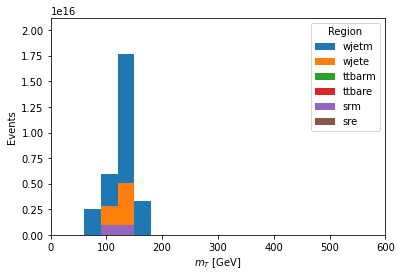

In [23]:
hist.plot1d(output['mT'].integrate('dataset'), overlay='region',stack=True)

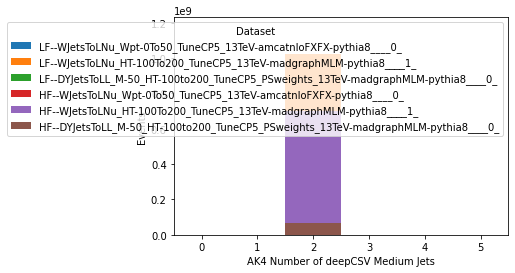

In [21]:
hist.plot1d(output['ndcsvM'].integrate('region', 'ttbarm'), overlay='dataset',stack=True)

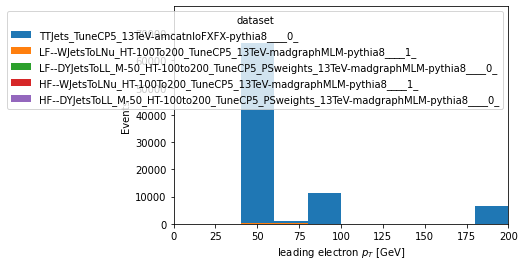

In [92]:
hist.plot1d(output['ele_leading_pT'].integrate('region', 'wecr'), overlay='dataset',stack=True)